In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt

In [3]:
dataset_dir = '/content/drive/MyDrive/Alzheimer_s Dataset/train/'

In [4]:
default_image_size = (128, 128)

def load_images_and_labels(dataset_dir):
    image_list, label_list = [], []
    for label in os.listdir(dataset_dir):
        folder_path = os.path.join(dataset_dir, label)
        for image_file in os.listdir(folder_path):
            if image_file.endswith('.jpg'):  # Filtre pour .jpg uniquement
                image_path = os.path.join(folder_path, image_file)
                image = tf.keras.utils.load_img(image_path, target_size=default_image_size)
                image_array = tf.keras.utils.img_to_array(image) / 255.0  # Normalisation
                image_list.append(image_array)
                label_list.append(label)
    return np.array(image_list), np.array(label_list)

image_list, label_list = load_images_and_labels(dataset_dir)
print(f"Total images loaded: {len(image_list)}")

Total images loaded: 5121


In [5]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)

# Diviser les données en ensembles d'entraînement et de test
x_train, x_test, y_train, y_test = train_test_split(image_list, image_labels, test_size=0.2, random_state=42)
print(f"Training samples: {len(x_train)}, Test samples: {len(x_test)}")

Training samples: 4096, Test samples: 1025


In [8]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

IMG_HEIGHT = 128
IMG_WIDTH = 128

# Charger les ensembles de données
train_ds = image_dataset_from_directory(
    "/content/drive/MyDrive/Alzheimer_s Dataset/train",  # Chemin vers le dossier d'entraînement
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=64
)

test_ds = image_dataset_from_directory(
    "/content/drive/MyDrive/Alzheimer_s Dataset/test",  # Chemin vers le dossier de test
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=64
)

# Obtenir les noms des classes
class_names = train_ds.class_names
print(class_names)

Found 5121 files belonging to 4 classes.
Found 1283 files belonging to 4 classes.
['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


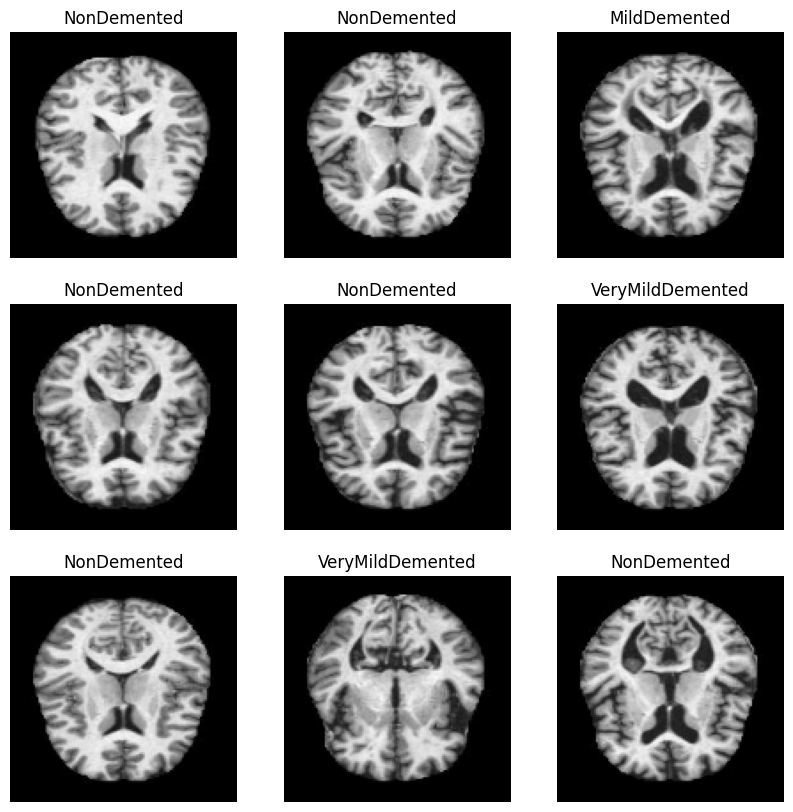

In [9]:
import matplotlib.pyplot as plt

# Afficher 9 images avec leurs noms de classes
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):  # Prendre un batch d'images
    for i in range(9):  # Afficher 9 images
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))  # Convertir l'image en format affichable
        plt.title(class_names[labels[i]])  # Afficher le nom de la classe
        plt.axis("off")  # Ne pas afficher les axes

plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

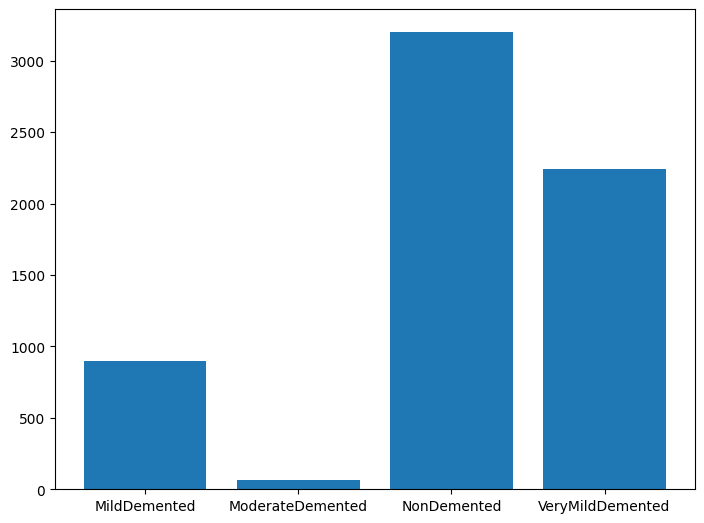

In [10]:
# to count the images in each class, then display it as histogram
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
size = [896,64,3200,2240]
ax.bar(class_names,size)
plt.show

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

aug = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [12]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))  # Ajout d'une couche de dropout pour réduire le sur-apprentissage
model.add(layers.Dense(len(label_binarizer.classes_), activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
from tensorflow.keras.optimizers import Adam

model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       4,719,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,109,572 (19.49 MB)

 Trainable params: 5,109,572 (19.49 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
from tensorflow.keras.applications import VGG16

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = True  # Dé-geler les couches pour le fine-tuning

# Ajouter des couches personnalisées
model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(len(label_binarizer.classes_), activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [16]:
from tensorflow.keras.callbacks import EarlyStopping

history = model.fit(
    aug.flow(x_train, y_train, batch_size=32),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // 32,
    epochs=100
)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


128/128 ━━━━━━━━━━━━━━━━━━━━ 63s 291ms/step - accuracy: 0.4724 - loss: 1.1211 - val_accuracy: 0.5220 - val_loss: 1.0343
Epoch 2/100


/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5220 - val_loss: 1.0343
Epoch 3/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 30s 232ms/step - accuracy: 0.5005 - loss: 1.0463 - val_accuracy: 0.5220 - val_loss: 1.0161
Epoch 4/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5220 - val_loss: 1.0161
Epoch 5/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 28s 215ms/step - accuracy: 0.4893 - loss: 1.0440 - val_accuracy: 0.5376 - val_loss: 0.9231
Epoch 6/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5376 - val_loss: 0.9231
Epoch 7/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 40s 215ms/step - accuracy: 0.5216 - loss: 0.9935 - val_accuracy: 0.5893 - val_loss: 0.8881
Epoch 8/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5893 - val_loss: 0.8881
Epoch 9/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 27s 203ms/step - accura

In [17]:
loss, accuracy = model.evaluate(x_test, y_test)
print(f"Test accuracy: {accuracy * 100:.2f}%")

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.8590 - loss: 0.4097
Test accuracy: 85.66%


In [18]:
model.save("my_model.h5")

33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step
                  precision    recall  f1-score   support

    MildDemented       0.92      0.74      0.82       128
ModerateDemented       0.00      0.00      0.00        11
     NonDemented       0.84      0.98      0.91       535
VeryMildDemented       0.87      0.74      0.80       351

        accuracy                           0.86      1025
       macro avg       0.66      0.61      0.63      1025
    weighted avg       0.85      0.86      0.85      1025



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


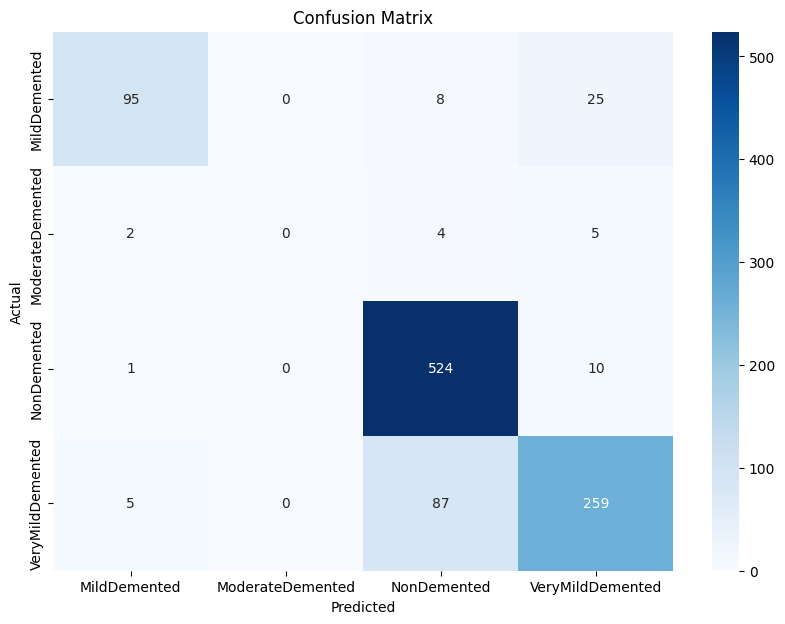

In [19]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Prédictions sur l'ensemble de test
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Rapport de classification
report = classification_report(y_true_classes, y_pred_classes, target_names=class_names)
print(report)

# Calcul de la matrice de confusion
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Affichage de la matrice de confusion
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step


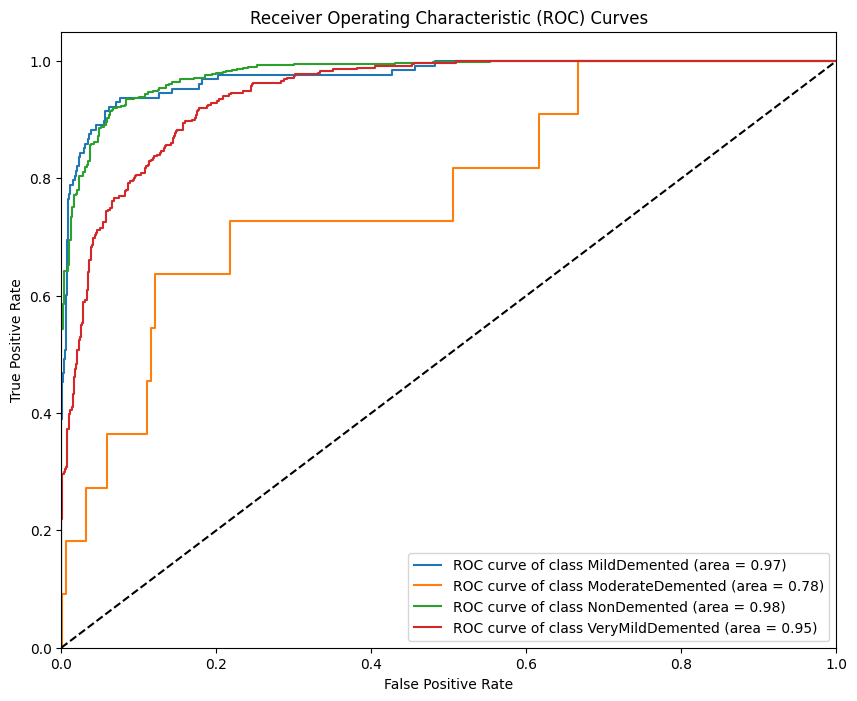

In [20]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binariser les étiquettes pour ROC
y_test_bin = label_binarize(y_true_classes, classes=np.arange(len(class_names)))
y_pred_prob = model.predict(x_test)

# Calculer les courbes ROC et AUC
fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Affichage des courbes ROC
plt.figure(figsize=(10, 8))
for i in range(len(class_names)):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(class_names[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')  # Diagonale
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc='lower right')
plt.show()

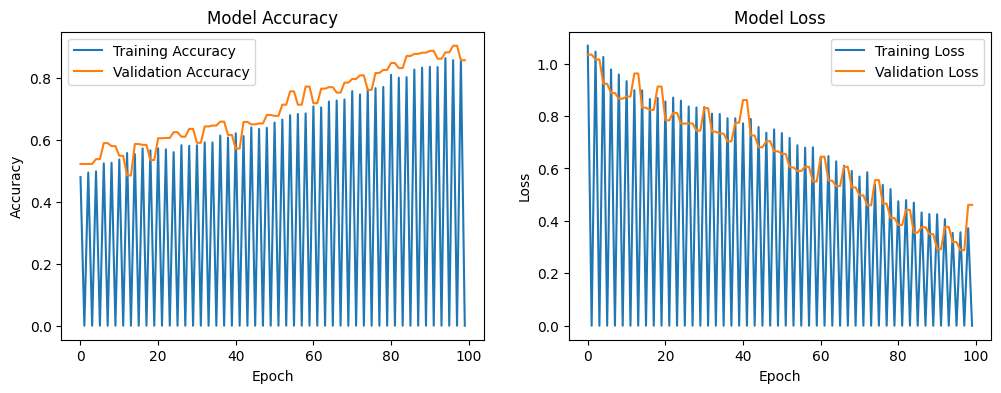

In [21]:
plt.figure(figsize=(12, 4))

# Précision
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Perte
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.show()